Value at Risk (VaR) Models Part 1
===

These models quantify the financial risk (later defined) given a a portfolio of assets. Quantifying this risk accurately helps protect against the worst case scenario (getting securities insurance, making hedged investments, adjusting the portfolio allocation to lower the VaR statistic; also determines if a firm is overexposed). We will define here a portfolio $P$ and be calculating its VaR statistic.

* Suppose I were to state that portfolio $P$ has a 5% two-month VaR of 7%, this implies that the assets in portfolio $P$ are likely to lose 7% of their value (maybe in different proportions, but averaging out to a loss of 7%) with a 5% chance over a 2-month period. 

* Similarly, a weekly VaR of USD 20,000 on a 95% confidence interval on portfolio implies that there is a 5% chance that the value of the investment decreases by more than USD 20,000 in a week.

|Advantages|Disadvantages|
|---|---|
|Single % number - easy to interpret and convey|No protocol to statistical testing or data collection (though there is an industry common practice precedent)|
|VaR computations can be compared across different types of assets—shares, bonds, derivatives, currencies.|Gives the lower bound for loss (a 20% risk is still fulfilled on a loss of 50%)|
|It is very popular and so many versions are readily available (such as on bloomberg terminal).|Depending on the level of sophistication, the models can be very hard to maintain and so can have cascading errors.|


## Calculating VaR

### Variance and Covariance Method

Since VaR measures the probability of an asset losing value over time, we must be able to sufficiently estimate it's distribution (very often we assume the normal distribution for its simplicity but that may not necessarily be appropriate). Knowing the distribution can help us calculate the variance and covariance thus making this computation simple. It is estimating the distribution that requires effort.

The central inputs to estimating the variance of a portfolio
are the covariances of the pairs of assets in the portfolio; in a portfolio of 100 assets, there
will be 49,500 covariances that need to be estimated, in addition to the 100 individual
asset variances. Clearly, this is not practical for large portfolios with shifting asset
positions.
It is to simplify this process that we map the risk in the individual investments in
the portfolio to more general market risks, when we compute Value at Risk, and then
estimate the measure based on these market risk exposures

### Historical Method

We use historical price performance to estimate a VaR for a certain historical eriod (for example over a year) and we then declare a VaR statistic based on realised volatility and expected returns. This is a lot more intuitive and less computationally exhaustive but leaves us exposed to fat-tailed risk.

Typically (by convention of Modern Portfolio Theory), a well-balanced portfolio should be able to minimise the likelihood of a fat-tail risk as it reduces skewness and kurtosis of a normally approximable random variable.
TLDR: A 'balanced' portfolio should be able to give you a manageable maximal risk given a sound dataset.

In [70]:
# dependecies
import yfinance as yf
import numpy as np
import statsmodels as statsmod
import matplotlib.pyplot as plt
import pandas as pd 
import statistics as stats

In [71]:
# using the USDGBP pair, making it usable for Pandas
usdgbp = yf.Ticker("USDGBP=X")
usdgbp.info
price_USDGBP = usdgbp.history(period = "1y")
price_USDGBP
df = pd.DataFrame(price_USDGBP)
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-02-20 00:00:00+00:00,0.83137,0.83226,0.829430,0.83127,0,0.0,0.0
2023-02-21 00:00:00+00:00,0.83076,0.83394,0.823460,0.83062,0,0.0,0.0
2023-02-22 00:00:00+00:00,0.82577,0.82929,0.824020,0.82581,0,0.0,0.0
2023-02-23 00:00:00+00:00,0.82994,0.83240,0.828130,0.82988,0,0.0,0.0
2023-02-24 00:00:00+00:00,0.83213,0.83812,0.830520,0.83210,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-02-13 00:00:00+00:00,0.79192,0.79505,0.788430,0.79192,0,0.0,0.0
2024-02-14 00:00:00+00:00,0.79420,0.79764,0.792959,0.79424,0,0.0,0.0
2024-02-15 00:00:00+00:00,0.79566,0.79728,0.793870,0.79565,0,0.0,0.0


In [72]:
# removing stuff we don't need, we only want the pair exchange rate in this case
df = df.drop(['Volume','Dividends','Stock Splits', 'High', 'Low', 'Open'], axis=1)
df

,Close
Date,
2023-02-20 00:00:00+00:00,0.83127
2023-02-21 00:00:00+00:00,0.83062
2023-02-22 00:00:00+00:00,0.82581
2023-02-23 00:00:00+00:00,0.82988
2023-02-24 00:00:00+00:00,0.83210
...,...
2024-02-13 00:00:00+00:00,0.79192
2024-02-14 00:00:00+00:00,0.79424
2024-02-15 00:00:00+00:00,0.79565


Text(0.5, 1.0, 'Price Performance of USDGBP')

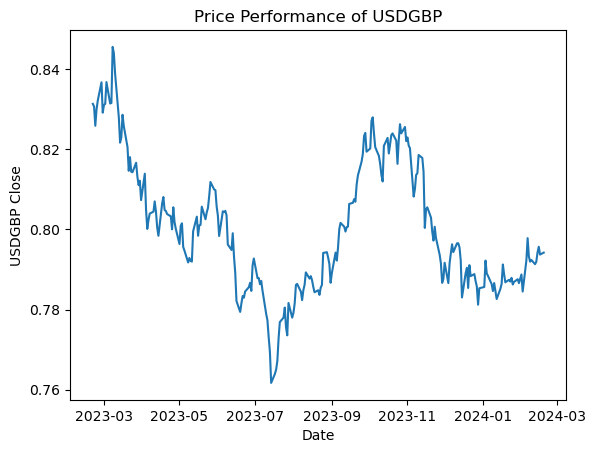

In [73]:
plt.plot(df)
plt.xlabel('Date')
plt.ylabel('USDGBP Close')
plt.title("Price Performance of USDGBP")

In [74]:
# let's create a return series to better understand the annual performance of the USDGBP pair 
# (assume we're long, its simple that way in term of units and signs)
price_series_USDGBP = pd.Series(df["Close"])
returns_series_USDGBP = price_series_USDGBP.pct_change() * 100
returns_USDGBP = pd.DataFrame(returns_series_USDGBP)
returns_USDGBP = returns_USDGBP.rename(columns={"Close":"Returns"})
returns_USDGBP

,Returns
Date,
2023-02-20 00:00:00+00:00,NaN
2023-02-21 00:00:00+00:00,-0.078192
2023-02-22 00:00:00+00:00,-0.579083
2023-02-23 00:00:00+00:00,0.492847
2023-02-24 00:00:00+00:00,0.267506
...,...
2024-02-13 00:00:00+00:00,0.077087
2024-02-14 00:00:00+00:00,0.292958
2024-02-15 00:00:00+00:00,0.177529


In [75]:
# Expected returns
E_returns = returns_USDGBP.mean(axis=0)
E_returns

Returns   -0.016442
dtype: float64

### We have an expected return of -0.016% (3dp) everyday should we have a long USDGBP position the past year.

Funnily enough, a very simple short daily algorithm, maybe 3 lines worth of code, would make you that return but commission is typically 0.025% on the NYSE so you would make a loss.

In [76]:
running_mean_return = returns_USDGBP['Returns'].expanding().mean()
cum_mean_returns_USDGBP = pd.DataFrame(running_mean_return)
cum_mean_returns_USDGBP.rename(columns={"Returns":"Cumulative Mean"})

,Cumulative Mean
Date,
2023-02-20 00:00:00+00:00,NaN
2023-02-21 00:00:00+00:00,-0.078192
2023-02-22 00:00:00+00:00,-0.328637
2023-02-23 00:00:00+00:00,-0.054809
2023-02-24 00:00:00+00:00,0.025770
...,...
2024-02-13 00:00:00+00:00,-0.017820
2024-02-14 00:00:00+00:00,-0.016611
2024-02-15 00:00:00+00:00,-0.015859


Text(0.5, 1.0, 'Returns Series')

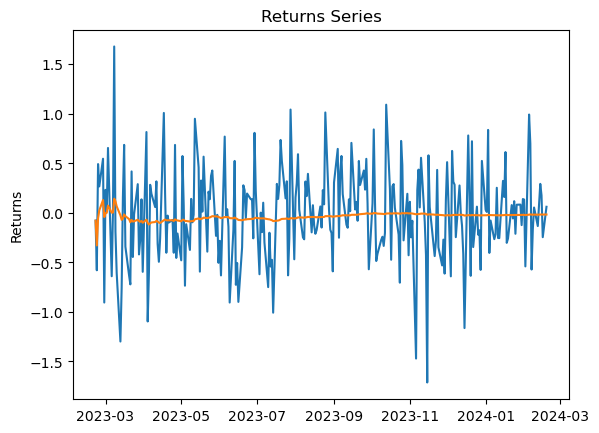

In [77]:
plt.plot(returns_USDGBP)
plt.plot(cum_mean_returns_USDGBP)
plt.ylabel('Returns')
plt.title("Returns Series")
# We are plotting the returns series and plotting the "running average" alongside to see whether
# we can say that the data does in fact possess time series properties such as stationarity and following a distribution

Text(0.5, 1.0, 'Frequency Distribution of Returns')

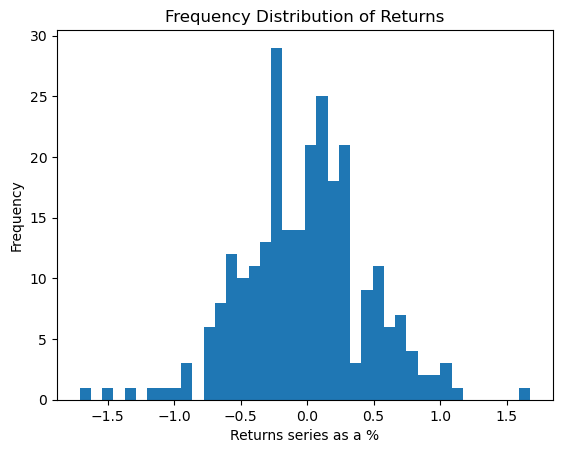

In [78]:
plt.hist(returns_USDGBP, bins =40)
plt.xlabel("Returns series as a %")
plt.ylabel("Frequency")
plt.title("Frequency Distribution of Returns")

##### Evidently we do not have a large enough sample to declare a distribution but we could compute the sample metrics for the data and try and do statistical tests to estimate the error with which we could declare the sample data of a specific distribution - we will not do that here, instead we assume normality.

#### We cannot yet assume stationarity but for the sake of argument lets assume that the mean and variance converge in terms of an estimate distribution (think sample means, sample variances), and we end up with a familiar (though practically a bit inefficient and often times simplistic, sometimes wrong, model) lets say returns are normally distributed.

In [79]:
# calculating variance to then work towards realised volatility 
# you would typically work towards making an implied volatility model in an actual work environment that is future looking
# but that requires actual maths instead of data science and is something I will leave as an exercise to those of you who are keen :D
var_USDGBP = returns_USDGBP["Returns"].var()
var_USDGBP

0.22225340011807887

In [80]:
# beware, this is a very implistic measure of volatility but it isn't entirely unfounded
volatility_USDGBP = np.sqrt(var_USDGBP)
volatility_USDGBP

0.47143758878358316

##### Using what we know about the normal distribution, we know 99% of all observations fall within 2.33 standard deviations of the mean, so to find the 5% VaR we just multiply the volatility by 2.33 by the position to get an estimate of the 99% VaR (i.e. the 1% worst-case outcome).

In [81]:
# Let us consider a position of USD 1000 for whatever GBP we can get in Mar 2023.

VaR = 1000 * (-E_returns + 1.64 * volatility_USDGBP)
print(VaR)

Returns    789.59945
dtype: float64


# There is a 5% chance that on any given trading day you lose a maximum of USD 790 of value in GBP.

##### We have computed a "one-asset VaR" for the USDGBP pair. Extensive error testing and looking at data is crucial to making sure you're not making spurious connections! Typically the issue of "fat-tails" associated with normally distributed time series data is erased with the construction of a stationary portfolio mostly because the distributions themselves aren't normal (typically equity price movement with a reasonably medium Beta is n chi-squared distributed).

# PV01 & DV01

To continue onto measuring and computing the VaR and overall sensitivity of a portfolio of various securities (options, futures and other securities with a computable shortfall) we must be able to compute the PV01.

**_PV01 is the sensitivity of the total scheme assets to a one basis point (1 bps or 0.01 per cent) change in interest rates. It is measured in the denominator currency (typically USD). It stands for "Present Value per 1 bp annuity" i.e. the present value should there be a 1bp movement in the price of securities or the interest rate i.e. a 0.01% move_**

We must also be able to calculate the nominal sensitivity of bonds that are often used to approximate a fixed income product such as a portfolio of assets (because we want to be able to reliably draw an income from a portfolio as portfolio managers)

**_Mathematically, the dollar duration measures the change in the value of a bond portfolio for every 100 basis point change in interest rates. Dollar duration is often referred to formally as DV01 (i.e. dollar value per 01). Remember, 0.01 is equivalent to 1 percent, which is often denoted as 100 basis points (bps)._**

### Maximum Drawdown

It is defined as:

$$ \frac{K-P}{P}$$

Where $P$ is the peak value of a portfolio over the investment period and $K$ is the trough value of the portfolio over the investment period. This should be a negative integer (except when the invetment has not ever lost value below the initial capital amount) and is a fairly concise way to historically evaluate the performance of an investment. We can also use this to compute RoMDD (Return over Maximum Drawdown) which is useful given we already have a return series! We can also compute a portfolio's Calmar Ratio.

In [82]:
# computing the MDD for the 1 year period for March 2023 to 2024
P = price_series_USDGBP.max()
K = price_series_USDGBP.min()
MDD = (K-P)/P
MDD

-0.09908102662931075

### Calmar Ratio

Made by William Sharpe (of the ever-present Sharpe Ratio), the Calmar Ratio gauges the performance of a portfolio with a focus on drawdown and is defined as:
$$\frac{R_p-R_t}{D_{max}}$$

Where $R_p$ is the portfolio return, $R_t$ the target return (there are systematic ways to calculate this but lets set it to an arbitrary but reasonable number) and $D_max$ is the Maximum Drawdown.

In [83]:
# Computing the Calmar Ratio series for the 1 year period for March 2023 to 2024
Calmar_series = (returns_series_USDGBP-1)/MDD

# Let us set the target return to 1%, as an arbitrary figure just to see how this investment would perform.

Calmar_df = pd.DataFrame(Calmar_series)
Calmar_df.rename(columns={"Close":"Calmar Ratio"})


,Calmar Ratio
Date,
2023-02-20 00:00:00+00:00,NaN
2023-02-21 00:00:00+00:00,10.881924
2023-02-22 00:00:00+00:00,15.937285
2023-02-23 00:00:00+00:00,5.118563
2023-02-24 00:00:00+00:00,7.392883
...,...
2024-02-13 00:00:00+00:00,9.314734
2024-02-14 00:00:00+00:00,7.136000
2024-02-15 00:00:00+00:00,8.300992


In [84]:
# Let us also compute the running mean of the Calmar Series, to see the long-term effect of a compounding.

# running_mean_return = returns_USDGBP['Returns'].expanding().mean() 
# cum_mean_returns_USDGBP = pd.DataFrame(running_mean_return)
# cum_mean_returns_USDGBP.rename(columns={"Returns":"Cumulative Mean"})

running_mean_calmar = Calmar_df['Close'].expanding().mean()
cum_mean_Calmar = pd.DataFrame(running_mean_calmar)
cum_mean_Calmar.rename(columns={"Close":"Cumulative Mean of Calmar"})

,Cumulative Mean of Calmar
Date,
2023-02-20 00:00:00+00:00,NaN
2023-02-21 00:00:00+00:00,10.881924
2023-02-22 00:00:00+00:00,13.409605
2023-02-23 00:00:00+00:00,10.645924
2023-02-24 00:00:00+00:00,9.832664
...,...
2024-02-13 00:00:00+00:00,10.272606
2024-02-14 00:00:00+00:00,10.260401
2024-02-15 00:00:00+00:00,10.252807


Text(0.5, 1.0, 'Calmar Ratio Time Series')

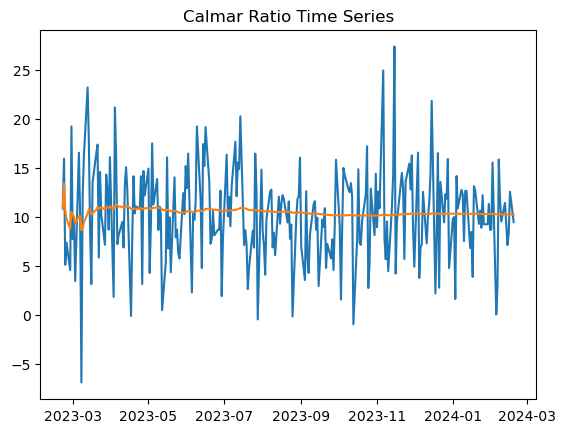

In [85]:
# plotting the Calmar Series on an intraday level to see what a simple long-to-close strategy for the USDGBP pair would perform.
plt.plot(Calmar_df)
plt.plot(cum_mean_Calmar)
plt.title("Calmar Ratio Time Series")

We see a convergence in the Calmar Ratio as well but that is not indicative of much, that would happen with any asset that has a reasonably low beta relative to its "value".

**Please note that we've used a constant MDD here which isn't optimum in a model given that we've taken a "runnig average" of the Calmar series but it helps visualise the idea that over time we see a constant mean for the Calmar Ratio.**

### Expected Shortfall or CVaR (Conditional Value at Risk)

As the name suggests, this is defined as what the expected loss on a portfolio of securities would be should a tail-risk be realised (a move more than 3 standard deviations from the mean). It is calculating taking the mean of returns in the worst 5% of cases (which should all be fairly large negative percentage values given that they are at the furthest edges of the bell curve).

#### Broaching this topic would need a primer in Bayesian Statistics (something I am not very familiar with myself) and so will be covered in another session.